In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
import xarray as xr
import seaborn as sns
from matplotlib.patches import Rectangle
import pandas as pd
from catboost import CatBoostClassifier

import matplotlib

font = {"size": 14}
matplotlib.rc("font", **font)

In [2]:
PERIOD = "2040_2050"
SSP = "ssp245"

### Defining paths 

In [3]:
# defining paths
path_to_npys_data = os.path.join("..", "data", "npys_data")

path_to_tifs_data = os.path.join("..", "data", "processed_files", "tifs")

pathTarget = os.path.join(path_to_npys_data, "target_croplands.npy")

pathPredictionMlp = os.path.join("..", "data", "results", PERIOD, f"mlp_{SSP}_AVG_prob.npy")
pathPredictionLstm = os.path.join("..", "data", "results", PERIOD, f"lstm_{SSP}_AVG_prob.npy")
pathPtlredictionConv_lstm = os.path.join(
    "..", "data", "results", PERIOD, f"conv_lstm_{SSP}_AVG_prob.npy"
)
pathPredictionTrans = os.path.join(
    "..", "data", "results", PERIOD, f"transformer_{SSP}_AVG_prob.npy"
)
pathPredictionCatboost = os.path.join(
    "..", "data", "results", PERIOD, f"catboost_{SSP}_AVG_prob.npy"
)
pathPredictionXgboost = os.path.join(
    "..", "data", "results", PERIOD, f"xgboost_{SSP}_AVG_prob.npy"
)
pathPredictionLr = os.path.join("..", "data", "results", PERIOD, f"lr_{SSP}_AVG_prob.npy")
pathPredictionLgbm = os.path.join("..", "data", "results", PERIOD, f"lgbm_{SSP}_AVG_prob.npy")

path_to_results = os.path.join("..", "data", "results", "prob_subs")

### Loading required datasets

In [4]:
# Loading GFSAD cropmask and use it as initial probability distribution. Class 4 denotes Nans in the dataset.

with open(pathTarget, "rb") as f:
    init_data = pickle.load(f)
    tgt = init_data["Target"]
    # Set classes 4,5 to 0
    tgt = tgt.astype(np.int16)
    tgt = np.where(tgt > 3, 0, tgt)
    uniques = np.unique(tgt)
    n_values = len(uniques)
    tgt_ohe = np.eye(n_values)[tgt]
    init_data = tgt_ohe

In [5]:
# Load prediction and filters

# Predicted probabilites by LSTM model for 2050 year
with open(pathPredictionMlp, "rb") as f:
    PredictionMlp = pickle.load(f)

with open(pathPredictionLstm, "rb") as f:
    PredictionLstm = pickle.load(f)

with open(pathPtlredictionConv_lstm, "rb") as f:
    PredictionConv_lstm = pickle.load(f)

with open(pathPredictionTrans, "rb") as f:
    PredictionTrans = pickle.load(f)

PredictionTrans[np.isnan(PredictionTrans)] = 0

with open(pathPredictionXgboost, "rb") as f:
    PredictionXgboost = pickle.load(f)

with open(pathPredictionCatboost, "rb") as f:
    PredictionCatboost = pickle.load(f)

with open(pathPredictionLr, "rb") as f:
    PredictionLr = pickle.load(f)

with open(pathPredictionLgbm, "rb") as f:
    PredictionLgbm = pickle.load(f)

# Tif file where 0s represent water area (no cropland is possible)
filter_water = rxr.open_rasterio(
    os.path.join(path_to_tifs_data, "filter_water.tif")
).squeeze()

# Tif file where 0s represent area with slope > 5 degrees (no cropland is possible)
filter_slope = rxr.open_rasterio(
    os.path.join(path_to_tifs_data, "filter_slope.tif")
).squeeze()

In [6]:
y_probs = {
    "mlp": PredictionMlp,
    "lstm": PredictionLstm,
    "transformer": PredictionTrans,
    "convlstm": PredictionConv_lstm,
    "lr": PredictionLr,
    "lgbm": PredictionLgbm,
    "xgboost": PredictionXgboost,
    "catboost": PredictionCatboost,
}

X = pd.DataFrame()
for model, value in y_probs.items():
    X = pd.concat(
        [
            X,
            pd.DataFrame(
                value, columns=[f"{model}_prob_class{i}" for i in range(value.shape[1])]
            ),
        ],
        axis=1,
    )

In [7]:
meta_model = CatBoostClassifier()
meta_model.load_model(
    os.path.join("..", "results", "pickle_models", "meta_catboost.pkl")
)
predicted_prob = meta_model.predict_proba(X)

In [8]:
with open(
    os.path.join("..", "data", "results", PERIOD, f"metamodel_{SSP}_AVG_prob.npy"),
    "wb",
) as f:
    pickle.dump(predicted_prob, f, protocol=4)

### Plot probabilities difference with initial cropmask for prediction

Class diff 0


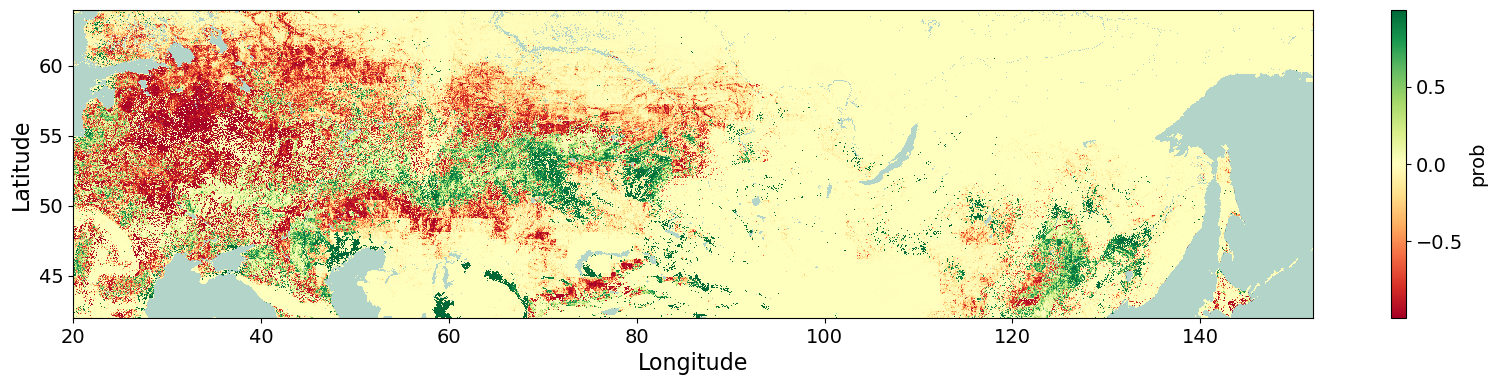

Class diff 1


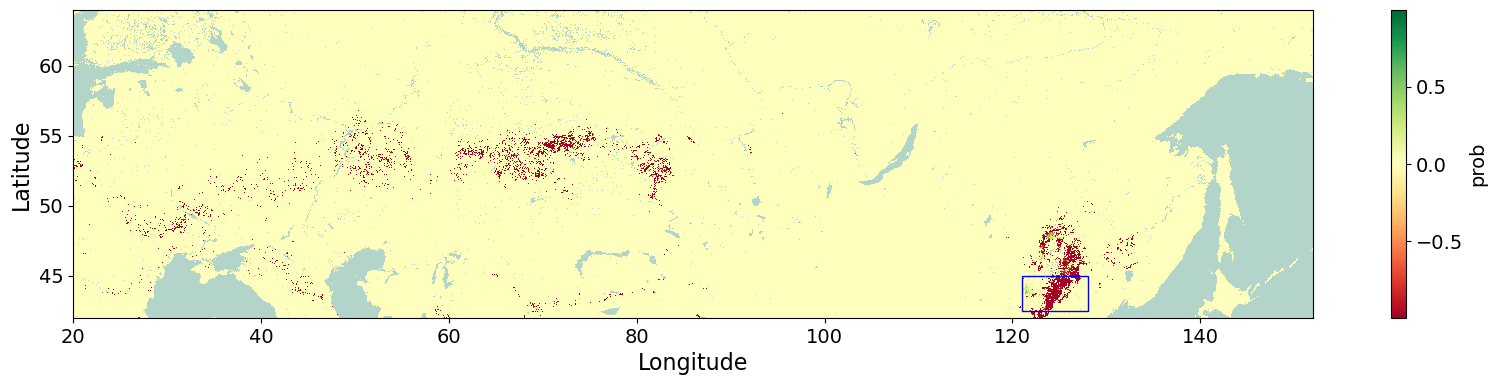

Class diff 2


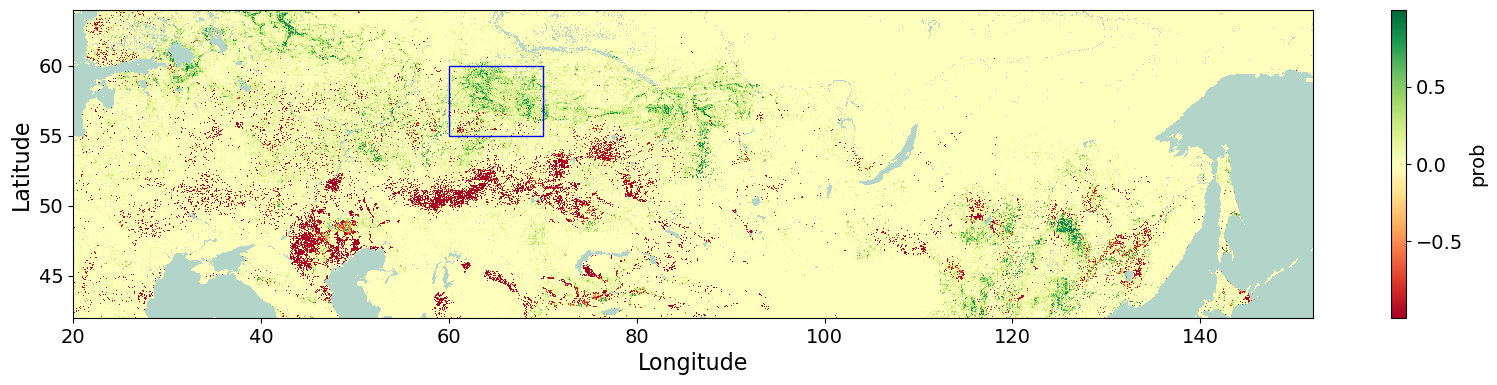

Class diff 3


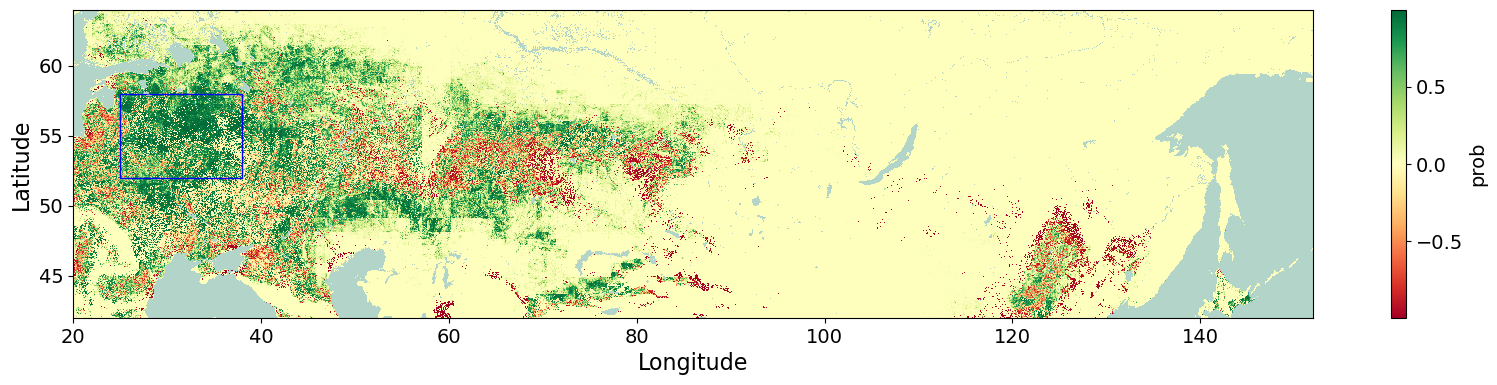

In [9]:
# Define dimensions for xr.DataArray based on Filter file:
x, y = filter_slope.x.values, filter_slope.y.values
lot = len(y)

# Iterate over classes and create heatmaps
for j in range(4):
    # Reshaping and filtering the probability arrays
    prob_filtered = (
        predicted_prob[:, j].reshape(lot, -1)
        * filter_water.values
        * filter_slope.values
    )
    init_filtered = (
        init_data[:, j].reshape(lot, -1) * filter_water.values * filter_slope.values
    )

    # Calculate difference in probabilities
    diff_probability = (prob_filtered - init_filtered).reshape(-1)

    # Defining rectangles for specific classes
    rectangles = [
        (
            45,
            121,
            42.5,
            128,
        ),  # Format: [ul_corner_y, ul_corner_x, lr_corner_y, lr_corner_x]
        (60, 60, 55, 70),
        (58, 25, 52, 38),
    ]

    filter_water_masked = filter_water.where(filter_water == 0)
    diff_probability_xr = xr.DataArray(
        diff_probability.reshape(lot, -1), dims=["y", "x"], coords={"y": y, "x": x}
    )
    diff_probability_xr.name = "prob"

    # Plotting setup
    fig, gax = plt.subplots(figsize=(20, 4))

    # Plot rectangle for classes 1, 2, and 3 (since j starts from 0)
    if j > 0:
        ul_corner_y, ul_corner_x, lr_corner_y, lr_corner_x = rectangles[j - 1]
        width, height = lr_corner_x - ul_corner_x, lr_corner_y - ul_corner_y
        rect = Rectangle(
            (ul_corner_x, ul_corner_y),
            width,
            height,
            linewidth=1,
            edgecolor="blue",
            facecolor="none",
        )
        gax.add_patch(rect)

    # Plot heatmap
    filter_water_masked.plot(ax=gax, cmap="Blues", add_colorbar=False, alpha=0.5)
    diff_probability_xr.plot.imshow(ax=gax, cmap="RdYlGn")
    filtered_diff_probability = diff_probability_xr + filter_water_masked

    plt.xlabel("Longitude", fontsize=16)
    plt.ylabel("Latitude", fontsize=16)
    filtered_diff_probability.rio.to_raster(os.path.join(path_to_results, f"metamodel_{SSP}_avg_class_diff_{j}.tif"))
    fig.savefig(
        os.path.join(path_to_results, f"metamodel_{SSP}_avg_class_diff_{j}.png"),
        dpi=100,
        format="png",
        bbox_inches="tight",
    )
    print(f"Class diff {j}")
    plt.show()
    plt.close(fig)